# TR-RB simulation

In [ ]:
 # ~~~
 # This file is part of the paper:
 #
 #   "Model Reduction for Large Scale Systems"
 #
 #   https://github.com/TiKeil/Petrov-Galerkin-TR-RB-for-pde-opt
 #
 # Copyright 2019-2021 all developers. All rights reserved.
 # License: Licensed as BSD 2-Clause License (http://opensource.org/licenses/BSD-2-Clause)
 # Authors:
 #   Tim Keil (2019 - 2021)
 # ~~~

# Preparations

## details

In this notebook we discretize the following problem: 
Find $u_{\mu}$ solving the following parametrized constrained equation

\begin{align*}
	-  \nabla \cdot \left( \kappa_{\mu}  \nabla u_{\mu} \right) &= f_{\mu} &&\text{in } \Omega, \\
	q ( \kappa_{\mu}  \nabla u_{\mu} \cdot n) &= (u_{\text{out}} - u_{\mu}) &&\text{on } \partial \Omega.
\end{align*}

For the definition of $\kappa_{\mu}$ and $f_{\mu}$ in the computational domain $\Omega$, we use the `BitmapFunction` from PyMOR. This function uses the Python Imaging Library (PIL) in order to convert a .png grayscale picture to a data function on our domain.
Walls, windows and doors are stored in seperated .png to enable a affine decomposition of each part of the picture. Furthermore, we are considering a heater at each window. The numbering of the components for $\kappa_{\mu}$ can be seen in the following picture
![EXC_notebook_data/EXC_MM_with_numbers.png](../../EXC_notebook_data/Domain_of_interestin_Omega.png)

Here, numbers with | are walls, numbers with _ are doors and numbers with dots are windows

The heaters are numbered in the following way:
![EXC_notebook_data/EXC_MM_with_numbers_heat.png](../../EXC_notebook_data/EXC_MM_with_numbers_heat.png)

For our pde constrained model, we need to define a cost functional. In a general quadratic model, we have 

\begin{align}
\mathcal{J}(u, \mu) := \Theta(\mu) + j_\mu(u) + k_\mu(u, u),
\end{align}

For this code, we restrict ourselves to the following definition
\begin{align}
\mathcal{J}(v, \mu) = \frac{\sigma_d}{2} \int_{D}^{} (v - u^{\text{d}})^2 + \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2,
\end{align}
which means

\begin{align}
\Theta(\mu) &= \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2 + \frac{\sigma_d}{2} \int_{D}^{} u^{\text{d}} u^{\text{d}}\\
j_{\mu}(u) & = -\sigma_d \int_{D}^{} u^{\text{d}}u \\
k_{\mu}(u,u) &= \frac{\sigma_d}{2} \int_{D}^{} u^2 
\end{align}

The following code implements this particular case.

## prepare cells

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})
np.warnings.filterwarnings('ignore') # silence numpys warnings

In [3]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
logger = getLogger('notebook.notebook')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

data_path = '../../../EXC_data'
# domain of interest
bounding_box = [[0,0],[2,1]]
# domain_of_interest = ConstantFunction(1,2)
domain_of_interest = BitmapFunction('{}/Domain_of_interest.png'.format(data_path), range=[1,0], bounding_box=bounding_box)

## problem definition and tolerances

In [4]:
from pdeopt.problems import EXC_problem, set_input_dict
from pdeopt.discretizer import discretize_quadratic_pdeopt_stationary_cg

parametric_quantities = {'walls': [1,4,9], 'windows': [], 'doors': [6,7], 'heaters': [1,3,5,6,7,8,9]}
inactive_quantities = {'removed_walls': [], 'open_windows': [], 'open_doors': [1,2,3,4,5,10], 'active_heaters': []}
summed_quantities = {'walls': [[1,2,3,7,8],[4,5,6]], 'windows': [], 'doors': [], 'heaters': [[1,2],[3,4],[9,10,11,12]]}

coefficient_expressions = None

parameters_in_q = True
input_dict = set_input_dict(parametric_quantities, inactive_quantities, coefficient_expressions, summed_quantities, parameters_in_q,
                            ac=0.5, owc=[0.025,0.1], iwc= [0.025,0.1], idc=[0.05,0.2], wc=[0.0005], ht=[0,100],
                                    owc_c=0.001,  iwc_c= 0.025,     idc_c=0.01,  wc_c=0.05,  ht_c=80)


parameter_scaling = False
u_out = 5

problem, parameter_scales = EXC_problem(input_dict, summed_quantities, outside_temperature=u_out, #, q_inverse=0.0001
                                        data_path = data_path,parameters_in_q=parameters_in_q, 
                                        parameter_scaling=parameter_scaling,
                                        coefficient_expressions=coefficient_expressions)

u_d = 18 

mu_d = problem.parameter_space.sample_randomly(1, seed=10)[0]
mu_d = None

sigma_d = 100
weights = {'walls': 0.1, 'doors': 1, 'heaters': [0.002,0.002,0.0005,0.0005,0.0005,0.0005,0.004], 'windows': 1, 'state': sigma_d}

diameter = np.sqrt(2)/200.
opt_fom, data, mu_bar = discretize_quadratic_pdeopt_stationary_cg(problem, diameter, weights, parameter_scales, 
                                                          domain_of_interest, desired_temperature=u_d, 
                                                          mu_for_u_d=mu_d, mu_for_tikhonov=mu_d,
                                                          parameters_in_q=parameters_in_q, product='fixed_energy')

I am using the NCD corrected functional!!
my product is fixed_energy
mu_bar is: {doors: [0.1, 0.1], heaters: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], walls: [0.049999999999999996, 0.049999999999999996, 0.049999999999999996]}


In [5]:
print('Information on the grid:')
print(data['grid'])

seed = 1                   # random seed for the starting value
radius = 0.1               # TR radius 
FOC_tolerance = 1e-6       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 60                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_FOM = 800           # Maximum number of iteration for the FOM method
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)
iterative_solver = 'CG'    # chosen iterative solver for Newton
control_mu = False         # parameter control disabled for this publication

# some implementational variables
Qian_Grepl_subproblem = True
reductor_type = 'simple_coercive'

Information on the grid:
Rect-Grid on domain [0,2] x [0,1]
x0-intervals: 400, x1-intervals: 200
faces: 80000, edges: 160600, vertices: 80601


In [6]:
# starting with 
parameter_space = problem.parameter_space
mu = parameter_space.sample_randomly(1, seed=seed)[0]

### What methods do you want to test ?

In [7]:
optimization_methods = [
    # FOM Method
    'BFGS',
    # BFGS
        # NCD-corrected from KMSOV'20
         'Method_8', # TR-RB
        # PG variant 
        'Method_8_pg', # TR-RB

    'Method_nc'
]

#optimization_methods = ['All']

## Visualizations

Visualize diffusion and rhs

In [8]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu.copy()
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
doI = InterpolationOperator(data['grid'], domain_of_interest).as_vector(vis_mu)

opt_fom.visualize(diff)

Output()

In [9]:
opt_fom.visualize(rhs)

Output()

In [10]:
opt_fom.visualize(doI)

Output()

We can easily solve the primal and dual equations by calling 

In [11]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)

Output()

In [12]:
opt_fom.visualize(p)

Output()

# Full Order Optimization

In [13]:
parameters = opt_fom.parameters
if mu_d is not None:
    mu_opt = mu_d
else:
    #use result from previous FOM run
    mu_opt = parameters.parse(np.array([5.000000000000e-02,  5.000000000000e-02,  2.238254711947e+01,
  2.339650455721e+01,  4.870348426512e+01,  4.937422778852e+01,
  5.236272251326e+01,  5.411556305764e+01,  2.352380079299e+01,
  2.500000000000e-02,  2.500000000000e-02,  2.500000000000e-02]))
    
mu_opt_as_array = mu_opt.to_numpy()
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', mu.to_numpy())
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [5.00000000e-02 5.00000000e-02 2.23825471e+01 2.33965046e+01
 4.87034843e+01 4.93742278e+01 5.23627225e+01 5.41155631e+01
 2.35238008e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02]
Optimal J:  5.813965062384796

Starting parameter:  [1.12553301e-01 1.58048674e-01 1.14374817e-02 3.02332573e+01
 1.46755891e+01 9.23385948e+00 1.86260211e+01 3.45560727e+01
 3.96767474e+01 6.54112551e-02 5.64395886e-02 7.63914625e-02]
Starting J:  70.71939494173489


In [14]:
print(mu_opt.parameters)

{doors: 2, heaters: 7, walls: 3}


## FOM BFGS

In [15]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_FOM,
                 'starting_parameter': mu,
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True}

if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    muoptfom,_,_,_, times_FOM, mus_FOM, Js_FOM, FOC_FOM = solve_optimization_subproblem_BFGS(opt_fom, problem.parameter_space,mu, TR_parameters, timing=True, FOM=True)
    times_full_FOM, J_error_FOM, mu_error_FOM, FOC = compute_errors(opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_FOM, Js_FOM, times_FOM, 0, FOC_FOM)
    times_full_FOM = times_full_FOM[1:]

Starting projected BFGS method
Starting parameter {doors: [0.1125533007053861, 0.15804867401632372], heaters: [0.011437481734488664, 30.233257263183976, 14.675589081711305, 9.233859476879779, 18.62602113776709, 34.556072704304775, 39.67674742306699], walls: [0.06541125505025178, 0.05643958858024711, 0.07639146252975697]}
Step [5.00000000e-02 5.00000000e-02 2.37980101e+00 3.26424662e+01
 1.59498829e+01 1.05278619e+01 2.00008293e+01 3.59623094e+01
 4.44630147e+01 2.50000000e-02 2.50000000e-02 1.00000000e-01], functional 35.89273776714299 , FOC condition 4.250608318521946
Step [5.00000000e-02 5.00000000e-02 1.12210416e+01 4.16110763e+01
 2.07138802e+01 1.53702356e+01 2.51536784e+01 4.12407658e+01
 6.22708292e+01 2.50000000e-02 2.50000000e-02 1.00000000e-01], functional 30.48038848361739 , FOC condition 3.811058563123798
Step [2.00000000e-01 2.00000000e-01 5.62536738e+00 3.59179445e+01
 1.76947602e+01 1.23005906e+01 2.18813005e+01 3.78810228e+01
 5.09387183e+01 1.00000000e-01 2.50000000e-0

Step [5.00000000e-02 5.00000000e-02 3.44129492e+01 3.78482301e+01
 3.30685223e+01 2.92887444e+01 3.79385860e+01 5.05107721e+01
 2.51622580e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.394234347682186 , FOC condition 0.04748283397780553
Step [5.00000000e-02 5.00000000e-02 3.38650936e+01 3.77275752e+01
 3.28177334e+01 2.90159127e+01 3.76744527e+01 5.02910452e+01
 2.55084829e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.391351427794234 , FOC condition 0.04773495261888243
Step [5.00000000e-02 5.00000000e-02 3.42961115e+01 3.77588974e+01
 3.30769164e+01 2.93022760e+01 3.79449600e+01 5.05041938e+01
 2.52084029e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.3887341816775916 , FOC condition 0.040604719288009676
Step [5.00000000e-02 5.00000000e-02 3.39284980e+01 3.76599259e+01
 3.29265399e+01 2.91399366e+01 3.77858766e+01 5.03684724e+01
 2.54338755e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 6.385848989298665 , FOC conditio

Step [5.00000000e-02 5.00000000e-02 2.91413294e+01 2.80450302e+01
 3.94024918e+01 3.67864048e+01 4.42666992e+01 5.41382408e+01
 2.55497621e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.988953064527095 , FOC condition 0.10684302426764046
Step [5.00000000e-02 5.00000000e-02 3.00278967e+01 2.83724391e+01
 3.96737880e+01 3.70722728e+01 4.45576792e+01 5.44053037e+01
 2.50314942e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.977219534428286 , FOC condition 0.022354265197894893
Step [5.00000000e-02 5.00000000e-02 2.91980536e+01 2.76585027e+01
 3.98342470e+01 3.72842629e+01 4.47054941e+01 5.44273249e+01
 2.53795625e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.969091239827094 , FOC condition 0.07860948983460887
Step [5.00000000e-02 5.00000000e-02 2.97060140e+01 2.77949702e+01
 4.00417459e+01 3.75082990e+01 4.49249955e+01 5.46145046e+01
 2.50654428e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.962114208777848 , FOC condition

Step [5.00000000e-02 5.00000000e-02 2.65659292e+01 2.05724676e+01
 4.52870750e+01 4.36789246e+01 5.01861585e+01 5.77385607e+01
 2.48587335e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.858929418226808 , FOC condition 0.011441646560220722
Step [5.00000000e-02 5.00000000e-02 2.64820152e+01 2.05032341e+01
 4.53016711e+01 4.36985176e+01 5.01994140e+01 5.77395598e+01
 2.48943584e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8588950417931756 , FOC condition 0.013617232578144416
Step [5.00000000e-02 5.00000000e-02 2.65412126e+01 2.05261902e+01
 4.53191494e+01 4.37168820e+01 5.02181851e+01 5.77569247e+01
 2.48599814e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8588324924003246 , FOC condition 0.011481226552117632
Step [5.00000000e-02 5.00000000e-02 2.64793329e+01 2.04701252e+01
 4.53354153e+01 4.37377109e+01 5.02335275e+01 5.77612255e+01
 2.48843866e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8587853547142 , FOC conditi

Step [5.00000000e-02 5.00000000e-02 2.62512653e+01 2.00406767e+01
 4.56646279e+01 4.41275581e+01 5.05617981e+01 5.79484191e+01
 2.48758449e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8580184539141555 , FOC condition 0.012502635043271267
Step [5.00000000e-02 5.00000000e-02 2.63067876e+01 2.00652339e+01
 4.56785310e+01 4.41419233e+01 5.05768598e+01 5.79629892e+01
 2.48442035e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8579763941463625 , FOC condition 0.01167264706341713
Step [5.00000000e-02 5.00000000e-02 2.62783450e+01 2.00485320e+01
 4.56776382e+01 4.41418467e+01 5.05753970e+01 5.79593468e+01
 2.48577909e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.857963691207715 , FOC condition 0.011708726423353678
Step [5.00000000e-02 5.00000000e-02 2.63115162e+01 2.00610246e+01
 4.56893928e+01 4.41544643e+01 5.05878535e+01 5.79701527e+01
 2.48374009e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.857952767417373 , FOC condit

Step [5.00000000e-02 5.00000000e-02 2.61280492e+01 1.99469467e+01
 4.58855722e+01 4.43949308e+01 5.07769577e+01 5.80528078e+01
 2.47966141e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.856200684024998 , FOC condition 0.012105877406440915
Step [5.00000000e-02 5.00000000e-02 2.60502767e+01 1.99142533e+01
 4.58751522e+01 4.43856903e+01 5.07646968e+01 5.80368787e+01
 2.48344861e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.856133850935976 , FOC condition 0.011944279109781986
Step [5.00000000e-02 5.00000000e-02 2.61004303e+01 1.99398719e+01
 4.58885523e+01 4.43998038e+01 5.07790161e+01 5.80499987e+01
 2.48041825e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.856061629311853 , FOC condition 0.011644996664002004
Step [5.00000000e-02 5.00000000e-02 2.58479317e+01 1.98557949e+01
 4.58837896e+01 4.44053741e+01 5.07670334e+01 5.80103455e+01
 2.49007453e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.855966465124084 , FOC conditi

Step [5.00000000e-02 5.00000000e-02 2.54417098e+01 2.03749005e+01
 4.62770023e+01 4.49185421e+01 5.11198968e+01 5.80634589e+01
 2.45711389e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.845699626003352 , FOC condition 0.010363306257077301
Step [5.00000000e-02 5.00000000e-02 2.50693802e+01 2.03407539e+01
 4.62798904e+01 4.49421017e+01 5.11089811e+01 5.79974338e+01
 2.46760672e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.845025797832477 , FOC condition 0.024628464004564515
Step [5.00000000e-02 5.00000000e-02 2.53609107e+01 2.04913349e+01
 4.63476678e+01 4.50121276e+01 5.11822234e+01 5.80681768e+01
 2.45058922e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.843961233132404 , FOC condition 0.01195727690427442
Step [5.00000000e-02 5.00000000e-02 2.51571407e+01 2.04375287e+01
 4.63289202e+01 4.49993764e+01 5.11574436e+01 5.80263929e+01
 2.45885769e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.843625156002872 , FOC conditio

Step [5.00000000e-02 5.00000000e-02 2.33918118e+01 2.18155850e+01
 4.71206125e+01 4.61007063e+01 5.18185196e+01 5.79000646e+01
 2.40524799e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.826052947680182 , FOC condition 0.022791878344166724
Step [5.00000000e-02 5.00000000e-02 2.35363484e+01 2.18872416e+01
 4.71519861e+01 4.61326480e+01 5.18527387e+01 5.79343867e+01
 2.39706143e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.825257189597778 , FOC condition 0.009084651063234955
Step [5.00000000e-02 5.00000000e-02 2.36188696e+01 2.19464037e+01
 4.71790473e+01 4.61625310e+01 5.18806509e+01 5.79561465e+01
 2.39116835e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.825035102094489 , FOC condition 0.0052642482478873626
Step [5.00000000e-02 5.00000000e-02 2.34074477e+01 2.19595853e+01
 4.71923833e+01 4.61911960e+01 5.18848225e+01 5.79199803e+01
 2.39525776e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.824663214655402 , FOC condit

Step [5.00000000e-02 5.00000000e-02 2.27135114e+01 2.27692540e+01
 4.76091075e+01 4.67612179e+01 5.22389412e+01 5.78852591e+01
 2.35834806e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.820236809063772 , FOC condition 0.0031447617188288253
Step [5.00000000e-02 5.00000000e-02 2.25762777e+01 2.27683741e+01
 4.76118780e+01 4.67724611e+01 5.22361529e+01 5.78599267e+01
 2.36172183e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.82019998678561 , FOC condition 0.008240256817147427
Step [5.00000000e-02 5.00000000e-02 2.26254626e+01 2.27940432e+01
 4.76230449e+01 4.67839718e+01 5.22482327e+01 5.78716626e+01
 2.35886220e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8201007211225715 , FOC condition 0.003870025143067181
Step [5.00000000e-02 5.00000000e-02 2.26757862e+01 2.28389721e+01
 4.76434000e+01 4.68071650e+01 5.22687262e+01 5.78856081e+01
 2.35472311e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.820063090480971 , FOC condit

Step [5.00000000e-02 5.00000000e-02 2.22656643e+01 2.31550177e+01
 4.78007153e+01 4.70318830e+01 5.23956696e+01 5.78401564e+01
 2.34439388e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819277883534369 , FOC condition 0.0026284528711239138
Step [5.00000000e-02 5.00000000e-02 2.22855407e+01 2.31740060e+01
 4.78091734e+01 4.70416140e+01 5.24041163e+01 5.78456296e+01
 2.34269424e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819270487523227 , FOC condition 0.002821987556782486
Step [5.00000000e-02 5.00000000e-02 2.22570930e+01 2.31682418e+01
 4.78069776e+01 4.70404229e+01 5.24009991e+01 5.78397075e+01
 2.34376535e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819261327225604 , FOC condition 0.002493713111320045
Step [5.00000000e-02 5.00000000e-02 2.22771924e+01 2.31975042e+01
 4.78201737e+01 4.70562341e+01 5.24137415e+01 5.78461250e+01
 2.34140825e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819254541174587 , FOC condit

Step [5.00000000e-02 5.00000000e-02 2.21148305e+01 2.33171012e+01
 4.78770436e+01 4.71390474e+01 5.24584558e+01 5.78242574e+01
 2.33794935e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819124867313349 , FOC condition 0.0023644777839350174
Step [5.00000000e-02 5.00000000e-02 2.20966233e+01 2.33191453e+01
 4.78781751e+01 4.71415969e+01 5.24587168e+01 5.78207761e+01
 2.33828352e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819122321003988 , FOC condition 0.0025395147648277347
Step [5.00000000e-02 5.00000000e-02 2.21077705e+01 2.33258109e+01
 4.78810431e+01 4.71446577e+01 5.24617448e+01 5.78234350e+01
 2.33758720e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819120303304089 , FOC condition 0.002377526513096146
Step [5.00000000e-02 5.00000000e-02 2.20952323e+01 2.33251395e+01
 4.78808836e+01 4.71451993e+01 5.24610808e+01 5.78208835e+01
 2.33794707e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819118960708465 , FOC condi

Step [5.00000000e-02 5.00000000e-02 2.20417338e+01 2.33889681e+01
 4.79099075e+01 4.71865886e+01 5.24844331e+01 5.78125741e+01
 2.33540499e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819091034967869 , FOC condition 0.0023929275417887332
Step [5.00000000e-02 5.00000000e-02 2.20340262e+01 2.33878767e+01
 4.79094951e+01 4.71865444e+01 5.24837194e+01 5.78108516e+01
 2.33567157e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8190905861736155 , FOC condition 0.0024149970631305163
Step [5.00000000e-02 5.00000000e-02 2.20386901e+01 2.33908288e+01
 4.79107629e+01 4.71879299e+01 5.24850341e+01 5.78119157e+01
 2.33537188e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81909008056391 , FOC condition 0.002388475643615454
Step [5.00000000e-02 5.00000000e-02 2.20279447e+01 2.33904268e+01
 4.79106854e+01 4.71885359e+01 5.24844674e+01 5.78095113e+01
 2.33567626e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819089512183382 , FOC condi

Step [5.00000000e-02 5.00000000e-02 2.20066520e+01 2.34248113e+01
 4.79264031e+01 4.72116895e+01 5.24965045e+01 5.78023931e+01
 2.33420006e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8190723690765935 , FOC condition 0.0024168388049521775
Step [5.00000000e-02 5.00000000e-02 2.19983588e+01 2.34224459e+01
 4.79254530e+01 4.72110210e+01 5.24952553e+01 5.78003385e+01
 2.33456154e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819071909715376 , FOC condition 0.002439137066988453
Step [5.00000000e-02 5.00000000e-02 2.20044475e+01 2.34255996e+01
 4.79268096e+01 4.72124608e+01 5.24966900e+01 5.78016192e+01
 2.33421402e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819071249990429 , FOC condition 0.0024079427032295156
Step [5.00000000e-02 5.00000000e-02 2.19935170e+01 2.34232113e+01
 4.79259022e+01 4.72120849e+01 5.24953077e+01 5.77987622e+01
 2.33464850e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819070684076905 , FOC cond

Step [5.00000000e-02 5.00000000e-02 2.19806283e+01 2.34447571e+01
 4.79377919e+01 4.72324541e+01 5.25021981e+01 5.77834520e+01
 2.33381426e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819032851288284 , FOC condition 0.0024123353359193685
Step [5.00000000e-02 5.00000000e-02 2.19936282e+01 2.34520104e+01
 4.79412252e+01 4.72366730e+01 5.25053965e+01 5.77847110e+01
 2.33305253e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819030276349622 , FOC condition 0.0026728142488079893
Step [5.00000000e-02 5.00000000e-02 2.19777864e+01 2.34455540e+01
 4.79385808e+01 4.72342924e+01 5.25022888e+01 5.77807577e+01
 2.33385792e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8190272805316 , FOC condition 0.002428031236763201
Step [5.00000000e-02 5.00000000e-02 2.19887341e+01 2.34510977e+01
 4.79411390e+01 4.72372742e+01 5.25047913e+01 5.77822505e+01
 2.33324647e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.819025246000365 , FOC conditi

Step [5.00000000e-02 5.00000000e-02 2.19885554e+01 2.34747749e+01
 4.79754168e+01 4.73140472e+01 5.25106055e+01 5.76753138e+01
 2.33254283e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81874326573211 , FOC condition 0.002937817396230042
Step [5.00000000e-02 5.00000000e-02 2.19674273e+01 2.34656027e+01
 4.79720704e+01 4.73116273e+01 5.25062214e+01 5.76682615e+01
 2.33366007e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.818732427900386 , FOC condition 0.0023670093464063773
Step [5.00000000e-02 5.00000000e-02 2.20292649e+01 2.34935083e+01
 4.79895205e+01 4.73380084e+01 5.25186957e+01 5.76575565e+01
 2.33051977e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.818720631302767 , FOC condition 0.006078877300633008
Step [5.00000000e-02 5.00000000e-02 2.19912915e+01 2.34768732e+01
 4.79825641e+01 4.73313003e+01 5.25108483e+01 5.76486844e+01
 2.33251358e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.818673017661695 , FOC conditi

Step [5.00000000e-02 5.00000000e-02 2.19941479e+01 2.34574184e+01
 4.80924522e+01 4.76260161e+01 5.24920810e+01 5.71373254e+01
 2.33667098e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.817433935224017 , FOC condition 0.002847802969370424
Step [5.00000000e-02 5.00000000e-02 2.20364264e+01 2.34750321e+01
 4.81039805e+01 4.76437746e+01 5.25000621e+01 5.71291014e+01
 2.33461412e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8173931809028545 , FOC condition 0.0027712650390413762
Step [5.00000000e-02 5.00000000e-02 2.19467682e+01 2.34298088e+01
 4.81046127e+01 4.76751142e+01 5.24775209e+01 5.70238176e+01
 2.34017017e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8173007845591655 , FOC condition 0.007873035742927987
Step [5.00000000e-02 5.00000000e-02 2.20661927e+01 2.34805832e+01
 4.81337704e+01 4.77159526e+01 5.25007914e+01 5.70170920e+01
 2.33420286e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.817150281512568 , FOC cond

Step [5.00000000e-02 5.00000000e-02 2.21875582e+01 2.34351901e+01
 4.84238965e+01 4.84859935e+01 5.24569569e+01 5.56943976e+01
 2.34187606e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814903706463383 , FOC condition 0.0015075102515662373
Step [5.00000000e-02 5.00000000e-02 2.22459222e+01 2.34529796e+01
 4.84555453e+01 4.85553729e+01 5.24632344e+01 5.56005811e+01
 2.33995038e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814835182059369 , FOC condition 0.005659456836298992
Step [5.00000000e-02 5.00000000e-02 2.21963121e+01 2.34315719e+01
 4.84441195e+01 4.85404576e+01 5.24532900e+01 5.55994588e+01
 2.34247687e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814793966076422 , FOC condition 0.0013075346751939697
Step [5.00000000e-02 5.00000000e-02 2.22694860e+01 2.34551383e+01
 4.84805539e+01 4.86183080e+01 5.24620461e+01 5.54984308e+01
 2.33988533e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814746092123414 , FOC condi

Step [5.00000000e-02 5.00000000e-02 2.23053405e+01 2.34188393e+01
 4.86093928e+01 4.89811167e+01 5.24265549e+01 5.48387622e+01
 2.34572805e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814170043427794 , FOC condition 0.002487833003833889
Step [5.00000000e-02 5.00000000e-02 2.22767032e+01 2.34060877e+01
 4.86033967e+01 4.89747328e+01 5.24202341e+01 5.48331776e+01
 2.34726431e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814160237817987 , FOC condition 0.0006063163172201885
Step [5.00000000e-02 5.00000000e-02 2.22889953e+01 2.34104057e+01
 4.86085064e+01 4.89851204e+01 5.24218609e+01 5.48208371e+01
 2.34678644e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8141530399689145 , FOC condition 0.0008195604271107908
Step [5.00000000e-02 5.00000000e-02 2.23100565e+01 2.34168559e+01
 4.86193366e+01 4.90091832e+01 5.24237545e+01 5.47876097e+01
 2.34611678e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.814142296893806 , FOC cond

Step [5.00000000e-02 5.00000000e-02 2.23562289e+01 2.34046874e+01
 4.86963919e+01 4.92309255e+01 5.23987168e+01 5.43764120e+01
 2.34914072e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813995149042057 , FOC condition 0.0015280063281472175
Step [5.00000000e-02 5.00000000e-02 2.23440306e+01 2.33998475e+01
 4.86924417e+01 4.92241842e+01 5.23964771e+01 5.43814941e+01
 2.34971057e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813992886344067 , FOC condition 0.0004510981310787195
Step [5.00000000e-02 5.00000000e-02 2.23580930e+01 2.34037587e+01
 4.87000270e+01 4.92423067e+01 5.23968261e+01 5.43538215e+01
 2.34936977e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813990365937116 , FOC condition 0.0014036207719023083
Step [5.00000000e-02 5.00000000e-02 2.23469497e+01 2.33993475e+01
 4.86963878e+01 4.92360730e+01 5.23947802e+01 5.43585837e+01
 2.34988950e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813988468729576 , FOC cond

Step [5.00000000e-02 5.00000000e-02 2.23660113e+01 2.33923274e+01
 4.87243369e+01 4.93325366e+01 5.23733219e+01 5.41538658e+01
 2.35221226e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813967124446435 , FOC condition 0.0007492184477414939
Step [5.00000000e-02 5.00000000e-02 2.23667754e+01 2.33925987e+01
 4.87246360e+01 4.93331509e+01 5.23734120e+01 5.41531212e+01
 2.35218324e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81396694200248 , FOC condition 0.0006859794182711525
Step [5.00000000e-02 5.00000000e-02 2.23674820e+01 2.33928494e+01
 4.87249125e+01 4.93337198e+01 5.23734947e+01 5.41524302e+01
 2.35215645e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813966786016408 , FOC condition 0.0006275559824897854
Step [5.00000000e-02 5.00000000e-02 2.23681354e+01 2.33930810e+01
 4.87251683e+01 4.93342466e+01 5.23735707e+01 5.41517886e+01
 2.35213174e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813966652627187 , FOC condi

Step [5.00000000e-02 5.00000000e-02 2.23720156e+01 2.33944508e+01
 4.87266880e+01 4.93374013e+01 5.23740033e+01 5.41478917e+01
 2.35198700e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813966074067594 , FOC condition 0.0002554089269956452
Step [5.00000000e-02 5.00000000e-02 2.23720549e+01 2.33944646e+01
 4.87267034e+01 4.93374336e+01 5.23740074e+01 5.41478510e+01
 2.35198556e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813966070054676 , FOC condition 0.0002522237624026515
Step [5.00000000e-02 5.00000000e-02 2.23720938e+01 2.33944783e+01
 4.87267187e+01 4.93374656e+01 5.23740115e+01 5.41478107e+01
 2.35198414e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8139660661147445 , FOC condition 0.00024906951916719473
Step [5.00000000e-02 5.00000000e-02 2.23721131e+01 2.33944851e+01
 4.87267263e+01 4.93374815e+01 5.23740135e+01 5.41477906e+01
 2.35198343e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813966064177521 , FOC co

Step [5.00000000e-02 5.00000000e-02 2.23755378e+01 2.33951322e+01
 4.87285282e+01 4.93447809e+01 5.23710740e+01 5.41314763e+01
 2.35222961e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965582527317 , FOC condition 6.171527851051324e-05
Step [5.00000000e-02 5.00000000e-02 2.23757635e+01 2.33954713e+01
 4.87282275e+01 4.93448823e+01 5.23711133e+01 5.41291152e+01
 2.35221748e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965559279268 , FOC condition 9.167661363918663e-05
Step [5.00000000e-02 5.00000000e-02 2.23763330e+01 2.33953391e+01
 4.87287332e+01 4.93460338e+01 5.23705780e+01 5.41280137e+01
 2.35226552e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965529654297 , FOC condition 7.761027911894166e-05
Step [5.00000000e-02 5.00000000e-02 2.23762267e+01 2.33954565e+01
 4.87285064e+01 4.93457079e+01 5.23707477e+01 5.41277801e+01
 2.35224785e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81396552274532 , FOC condi

Step [5.00000000e-02 5.00000000e-02 2.23798916e+01 2.33960327e+01
 4.87291149e+01 4.93502582e+01 5.23687060e+01 5.41146520e+01
 2.35237010e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965389142368 , FOC condition 4.232412180394067e-05
Step [5.00000000e-02 5.00000000e-02 2.23798210e+01 2.33960674e+01
 4.87290081e+01 4.93500596e+01 5.23687921e+01 5.41147271e+01
 2.35236098e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.81396538842796 , FOC condition 1.8742572991883898e-05
Step [5.00000000e-02 5.00000000e-02 2.23798956e+01 2.33960580e+01
 4.87290547e+01 4.93501854e+01 5.23687316e+01 5.41145557e+01
 2.35236582e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965387481858 , FOC condition 2.5094716102246142e-05
Step [5.00000000e-02 5.00000000e-02 2.23800420e+01 2.33960496e+01
 4.87291212e+01 4.93504001e+01 5.23686240e+01 5.41141862e+01
 2.35237350e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965386531436 , FOC con

Step [5.00000000e-02 5.00000000e-02 2.23810383e+01 2.33961582e+01
 4.87290980e+01 4.93512168e+01 5.23680421e+01 5.41112834e+01
 2.35239124e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965373211886 , FOC condition 2.121514095538975e-05
Step [5.00000000e-02 5.00000000e-02 2.23811234e+01 2.33961521e+01
 4.87291351e+01 4.93513372e+01 5.23679746e+01 5.41110848e+01
 2.35239558e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965372951088 , FOC condition 2.893740708570863e-05
Step [5.00000000e-02 5.00000000e-02 2.23810766e+01 2.33961692e+01
 4.87290740e+01 4.93512154e+01 5.23680216e+01 5.41111668e+01
 2.35239022e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965372799885 , FOC condition 1.8093636130297697e-05
Step [5.00000000e-02 5.00000000e-02 2.23811191e+01 2.33961638e+01
 4.87290995e+01 4.93512849e+01 5.23679861e+01 5.41110727e+01
 2.35239289e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965372527036 , FOC con

Step [5.00000000e-02 5.00000000e-02 2.23818017e+01 2.33961944e+01
 4.87291402e+01 4.93519016e+01 5.23674097e+01 5.41094546e+01
 2.35240805e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.8139653680054835 , FOC condition 2.5340584162770956e-05
Step [5.00000000e-02 5.00000000e-02 2.23817662e+01 2.33962027e+01
 4.87291072e+01 4.93518278e+01 5.23674384e+01 5.41095301e+01
 2.35240492e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965367848596 , FOC condition 1.920592027019373e-05
Step [5.00000000e-02 5.00000000e-02 2.23818159e+01 2.33961988e+01
 4.87291291e+01 4.93518992e+01 5.23673902e+01 5.41094248e+01
 2.35240737e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965367718993 , FOC condition 2.2685208016783175e-05
Step [5.00000000e-02 5.00000000e-02 2.23817874e+01 2.33962081e+01
 4.87290944e+01 4.93518292e+01 5.23674096e+01 5.41094865e+01
 2.35240418e+01 2.50000000e-02 2.50000000e-02 2.50000000e-02], functional 5.813965367618948 , FOC c

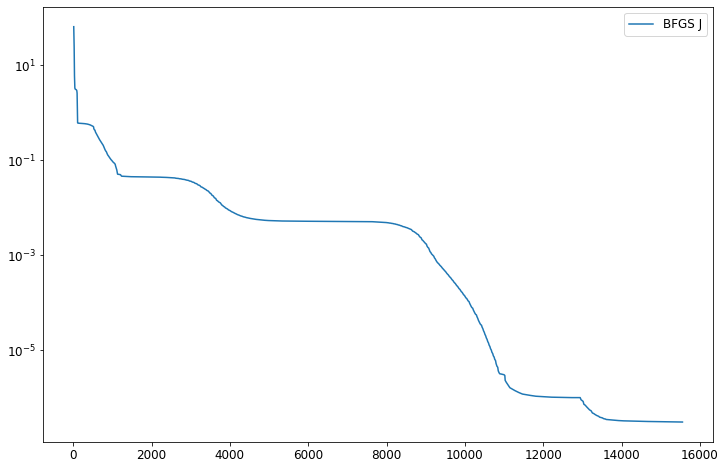

In [16]:
if 'BFGS' in optimization_methods or 'BFGS' in optimization_methods:
    plt.semilogy(times_full_FOM,J_error_FOM, label='BFGS J')
    plt.legend()

# TR-RB approaches

In [19]:
import time
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor
from pdeopt.TR import TR_algorithm

from pymor.parameters.functionals import MinThetaParameterFunctional
ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

set_defaults({'pymor.operators.constructions.induced_norm.raise_negative': False})
set_defaults({'pymor.operators.constructions.induced_norm.tol': 1e-20})

## NCD corrected BFGS Method (KMSOV'20)

In [28]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_8' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_8, times_8, Js_8, FOC_8, data_8 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_8_actual, J_error_8_actual, mu_error_8_actual, FOC_8_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_8, Js_8, times_8, tictoc, FOC_8)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.1125533007053861, 0.15804867401632372], heaters: [0.011437481734488664, 30.233257263183976, 14.675589081711305, 9.233859476879779, 18.62602113776709, 34.556072704304775, 39.67674742306699], walls: [0.06541125505025178, 0.05643958858024711, 0.07639146252975697]}
Starting value of the cost: 70.7193949665184
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of bases are 2 and 2
k: 0 - j 3 - Cost Functional: 41.145057016527346 - mu: {doors: [0.05, 0.05], heaters: [1.9671892439172975, 32.21240534794534, 15.727818883022534, 10.30290363981325, 19.7

Subproblem converged: FOC = 7.568148454138811e-07, mu_diff = 1.1050929679172856e-15, J_diff = 0.0 
relative differences mu 1.1050929679172856e-15 and J 0.0
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of bases are 12 and 12
k: 10 - j 177 - Cost Functional: 5.8139650630666395 - mu: {doors: [0.05, 0.05], heaters: [22.38256385032504, 23.396202811335982, 48.703656289672026, 49.3740955885908, 52.36281354329311, 54.11565785620202, 23.52387810955753], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 7.566494342685042e-07
******************************* 


Stopping criteria fulfilled: FOC condition: 7.566494342685042e-07
Computing only the initial FOC


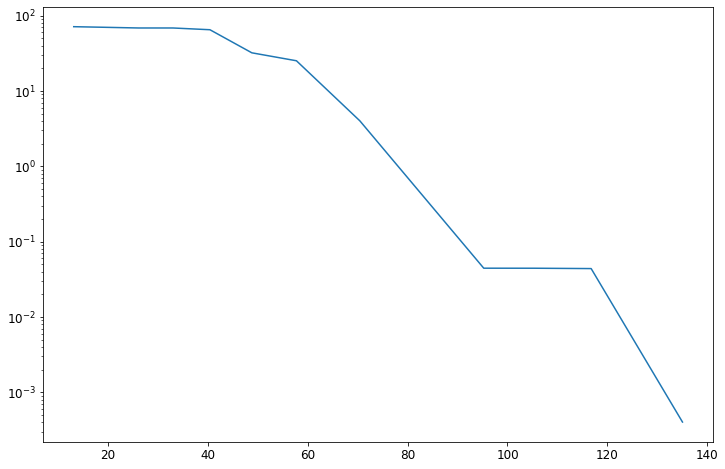

In [29]:
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual)

## Petrov-Galerkin approach

### BFGS

In [30]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
opt_fom_pg = opt_fom.with_(petrov_galerkin=True) 

from pdeopt.pg_reductor import QuadraticPdeoptStationaryCoercivePGReductor

if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoercivePGReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar,
                                                least_squares=True)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_8_pg, times_8_pg, Js_8_pg, FOC_8_pg, data_8_pg = TR_algorithm(opt_rom, pdeopt_reductor,
                                                                      parameter_space, 
                                                                      TR_parameters, extension_params)
    
    times_full_8_pg_actual, J_error_8_pg_actual, mu_error_8_pg_actual, FOC_8_pg_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_8_pg, Js_8_pg, times_8_pg, tictoc, FOC_8_pg)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.1125533007053861, 0.15804867401632372], heaters: [0.011437481734488664, 30.233257263183976, 14.675589081711305, 9.233859476879779, 18.62602113776709, 34.556072704304775, 39.67674742306699], walls: [0.06541125505025178, 0.05643958858024711, 0.07639146252975697]}
Starting value of the cost: 70.71939496651817
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of Bases are 2 and 2
k: 0 - j 3 - Cost Functional: 41.19991323001409 - mu: {doors: [0.05, 0.05], heaters: [1.96286940518779, 32.20786299137867, 15.72529679042625, 10.300293989290365, 19.758

building simple coercive dual reductor...
Enrichment completed... length of Bases are 12 and 12
k: 10 - j 400 - Cost Functional: 5.813965240747393 - mu: {doors: [0.05, 0.05], heaters: [22.38253798854122, 23.396510951736847, 48.703700892367664, 49.37409704515833, 52.36252940300968, 54.11570875566575, 23.523795701702443], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 9.03106073148227e-07
******************************* 


Stopping criteria fulfilled: FOC condition: 9.03106073148227e-07
Computing only the initial FOC


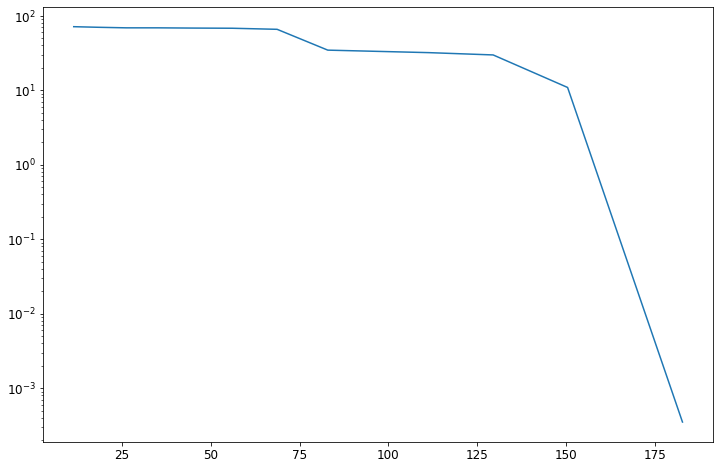

In [31]:
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,mu_error_8_pg_actual)

## Non corrected approach

In [36]:
tic = time.time()
params = [mu]

opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
opt_fom = opt_fom.with_(petrov_galerkin=False)

if 'Method_nc' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom_pg, params, build_sensitivities=False)


    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                                RBbasis, dual_RBbasis, 
                                                                opt_product=opt_fom.opt_product,
                                                                coercivity_estimator=ce,
                                                                mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = { 'Qian-Grepl_subproblem': Qian_Grepl_subproblem,  'beta': beta,
                     'safety_tolerance': safety_tol,
                     'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                     'sub_tolerance': sub_tolerance,
                     'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                     'max_iterations_armijo': max_it_arm,
                     'initial_step_armijo': init_step_armijo, 
                     'armijo_alpha': armijo_alpha, 
                     'epsilon_i': epsilon_i, 
                     'starting_parameter': mu,
                     'control_mu': control_mu,
                     'opt_method': 'BFGSMethod'}

    extension_params = {"Enlarge_radius": True, 'timings': True}

    mus_nc, times_nc, Js_nc, FOC_nc = TR_algorithm(
        opt_rom, pdeopt_reductor, parameter_space, TR_parameters, extension_params)

    times_full_nc_actual, J_error_nc_actual, mu_error_nc_actual, FOC_nc_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_nc, Js_nc, times_nc, tictoc, FOC_nc)


Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.1125533007053861, 0.15804867401632372], heaters: [0.011437481734488664, 30.233257263183976, 14.675589081711305, 9.233859476879779, 18.62602113776709, 34.556072704304775, 39.67674742306699], walls: [0.06541125505025178, 0.05643958858024711, 0.07639146252975697]}
Starting value of the cost: 70.71939496638606
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of bases are 2 and 2
k: 0 - j 3 - Cost Functional: 44.3505574568851 - mu: {doors: [0.05, 0.05], heaters: [1.6907123605836338, 31.93619943758962, 15.57899972852324, 10.151490830994055, 19.60

Subproblem converged: FOC = 3.494180069897169e-05, mu_diff = 4.259344386201963e-15, J_diff = 0.0 
relative differences mu 4.259344386201963e-15 and J 0.0
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of bases are 11 and 11
enlarging the TR radius to 12.8
k: 9 - j 118 - Cost Functional: 5.813964014155317 - mu: {doors: [0.05, 0.05], heaters: [22.379297390338277, 23.391599203001046, 48.695216903932476, 49.340701708976134, 52.362457486658755, 54.147911509424546, 23.529351009246234], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 3.625598518330194e-05
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Subproblem converged: FOC = 3.625499591715682e-05, mu_diff = 1.9632447537571754e-12, J_diff = 0.0 
relative differences mu 1.9632447537571754e-12 and J 0.0
enriching to ch

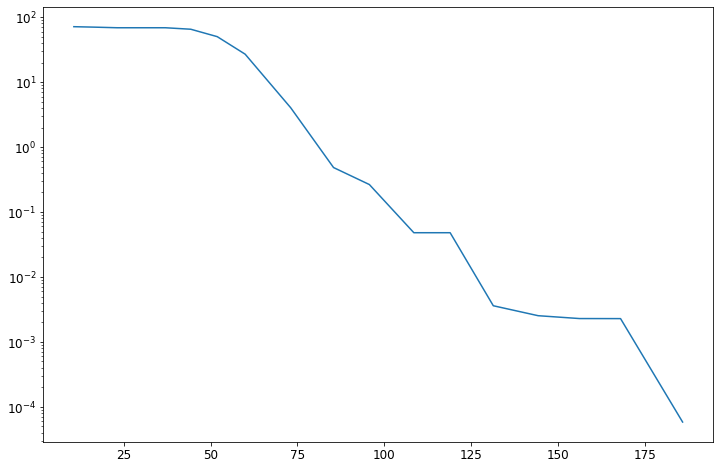

In [37]:
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual,mu_error_nc_actual)

# Results

In [38]:
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

Output()

## Plot results

### J error

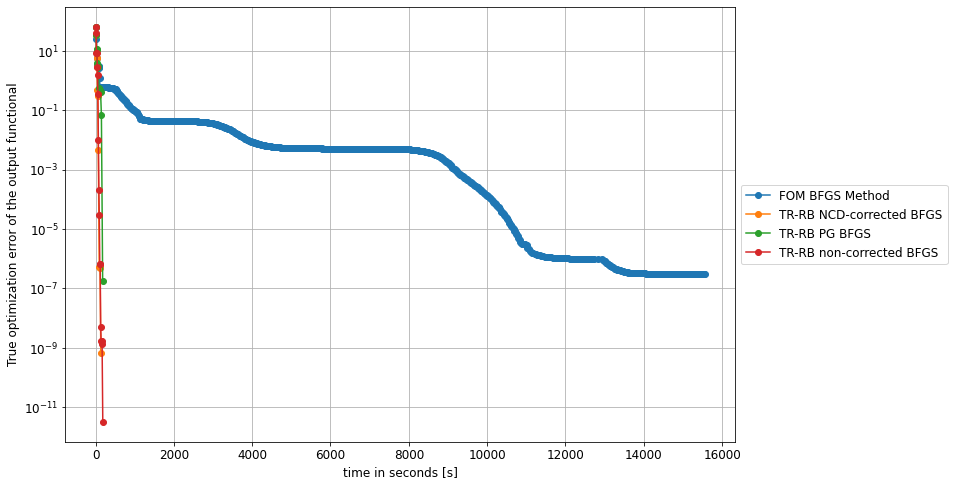

In [39]:
timings_figure = plt.figure()
if 'SH' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,J_error_SH,'o-', label='FOM SH Method')
if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM,J_error_FOM,'o-', label='FOM BFGS Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,J_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_4_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_pg_actual,J_error_4_pg_actual,'o-', label='4. PG Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,J_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_5_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_pg_actual,J_error_5_pg_actual,'o-', label='5. PG Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,J_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag. optional')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,J_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay. optional')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,J_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,J_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,J_error_8_actual,'o-', label='TR-RB NCD-corrected BFGS')
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,J_error_8_pg_actual,'o-', label='TR-RB PG BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,J_error_9_actual,'o-', label='9. Qian-Grepl')
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual, J_error_nc_actual,'o-', label='TR-RB non-corrected BFGS')

    
plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot FOC

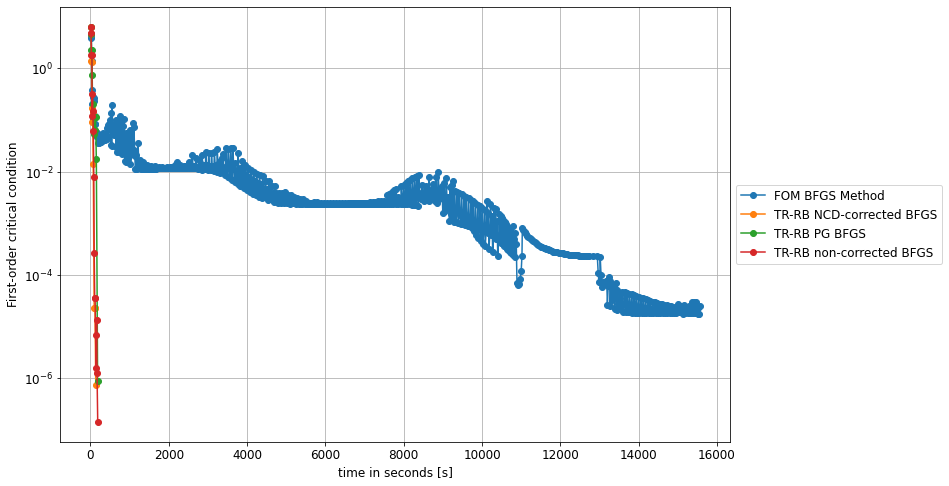

In [40]:
timings_figure = plt.figure()

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH, FOC_SH,'o-', label='FOM Method')
if 'BFGS' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_FOM, FOC_FOM,'o-', label='FOM BFGS Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual, FOC_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_4_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_pg_actual,FOC_4_pg_actual,'o-', label='4. PG Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual, FOC_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_5_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_pg_actual,FOC_5_pg_actual,'o-', label='5. PG Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual, FOC_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual, FOC_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual, FOC_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual, FOC_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual, FOC_8_actual,'o-', label='TR-RB NCD-corrected BFGS')
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,FOC_8_pg_actual,'o-', label='TR-RB PG BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual, FOC_9_actual,'o-', label='9. Qian-Grepl')
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual, FOC_nc_actual,'o-', label='TR-RB non-corrected BFGS')

    
plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot Mu error

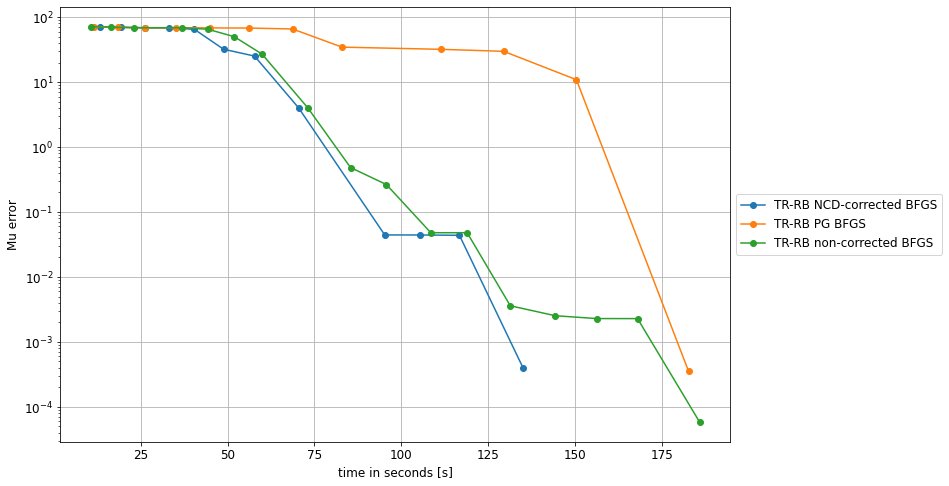

In [41]:
# if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
#     plt.semilogy(times_full_SH, mu_error_SH,'o-', label='FOM Method')
# if 'BFGS' in optimization_methods or 'All' in optimization_methods:
#     plt.semilogy(times_full_FOM, mu_error_FOM,'o-', label='FOM BFGS Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,mu_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_4_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_pg_actual,mu_error_4_pg_actual,'o-', label='4. PG Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,mu_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_5_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_pg_actual,mu_error_5_pg_actual,'o-', label='5. PG Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,mu_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,mu_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,mu_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,mu_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual,'o-', label='TR-RB NCD-corrected BFGS')
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_pg_actual,mu_error_8_pg_actual,'o-', label='TR-RB PG BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,mu_error_9_actual,'o-', label='9. Qian-Grepl')
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_nc_actual, mu_error_nc_actual,'o-', label='TR-RB non-corrected BFGS')

    
plt.xlabel('time in seconds [s]')
plt.ylabel('Mu error')
#plt.xlim([-1,100])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Save the data

In [42]:
#save data
from pdeopt.tools import save_data

directory = f'results/Starter{seed}'

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_SH, J_error_SH, 1, mu_error=mu_error_SH, FOC=FOC_SH)
if 'BFGS' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_FOM, J_error_FOM, 1, mu_error=mu_error_FOM, FOC=FOC_FOM)
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4_actual, J_error_4_actual, 4, mu_error=mu_error_4_actual, FOC=FOC_4_actual, additional_data=data_4)
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5_actual, J_error_5_actual, 5, mu_error=mu_error_5_actual, FOC=FOC_5_actual, additional_data=data_5)
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4bis_actual, J_error_4bis_actual, 2, mu_error=mu_error_4bis_actual, FOC=FOC_4bis_actual, additional_data=data_4bis)
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5bis_actual, J_error_5bis_actual, 3, mu_error=mu_error_5bis_actual, FOC=FOC_5bis_actual, additional_data=data_5bis)
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_6_actual, J_error_6_actual, 6, mu_error=mu_error_6_actual, FOC=FOC_6_actual, additional_data=data_6)
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_7_actual, J_error_7_actual, 7, mu_error=mu_error_7_actual, FOC=FOC_7_actual, additional_data=data_7)
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_8_actual, J_error_8_actual, 8, mu_error=mu_error_8_actual, FOC=FOC_8_actual, additional_data=data_8)
if 'Method_8_pg' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_8_pg_actual, J_error_8_pg_actual, 10, mu_error=mu_error_8_pg_actual, FOC=FOC_8_pg_actual, additional_data=data_8_pg)
if 'Method_nc' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_nc_actual, J_error_nc_actual, 11, mu_error=mu_error_nc_actual, FOC=FOC_nc_actual)
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_9_actual, J_error_9_actual, 9, mu_error=mu_error_9_actual, FOC=FOC_9_actual, additional_data=data_9)    